In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import gc
import cv2
import json
import time

import numpy as np
import pandas as pd
from pathlib import Path
from keras.utils import to_categorical

import seaborn as sns
import plotly.express as px
from matplotlib import colors
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

import torch
T = torch.Tensor
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
SIZE = 1000
EPOCHS = 50
CONV_OUT_1 = 50
CONV_OUT_2 = 100
BATCH_SIZE = 128

TEST_PATH = Path('/content/drive/My Drive/Colab Notebooks/project/abstraction-and-reasoning-challenge/')
SUBMISSION_PATH = Path('/content/drive/My Drive/Colab Notebooks/project/abstraction-and-reasoning-challenge/')

TEST_PATH = TEST_PATH / 'test'
SUBMISSION_PATH = SUBMISSION_PATH / 'sample_submission.csv'

test_task_files = sorted(os.listdir(TEST_PATH))

test_tasks = []
for task_file in test_task_files:
    with open(str(TEST_PATH / task_file), 'r') as f:
        task = json.load(f)
        test_tasks.append(task)

Xs_test, Xs_train, ys_train = [], [], []

for task in test_tasks:
    X_test, X_train, y_train = [], [], []

    for pair in task["test"]:
        X_test.append(pair["input"])

    for pair in task["train"]:
        X_train.append(pair["input"])
        y_train.append(pair["output"])

    Xs_test.append(X_test)
    Xs_train.append(X_train)
    ys_train.append(y_train)

matrices = []
for X_test in Xs_test:
    for X in X_test:
        matrices.append(X)

values = []
for matrix in matrices:
    for row in matrix:
        for value in row:
            values.append(value)

df = pd.DataFrame(values)
df.columns = ["values"]

data_path = Path('/content/drive/My Drive/Colab Notebooks/project/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
training_tasks = sorted(os.listdir(training_path))

In [9]:

evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'


evaluation_tasks = sorted(os.listdir(evaluation_path))
test_tasks = sorted(os.listdir(test_path))
print(f"There are {len(training_tasks)} traning tasks, {len(evaluation_tasks)} evaluation tasks and {len(test_tasks)} test tasks." )

There are 400 traning tasks, 400 evaluation tasks and 100 test tasks.


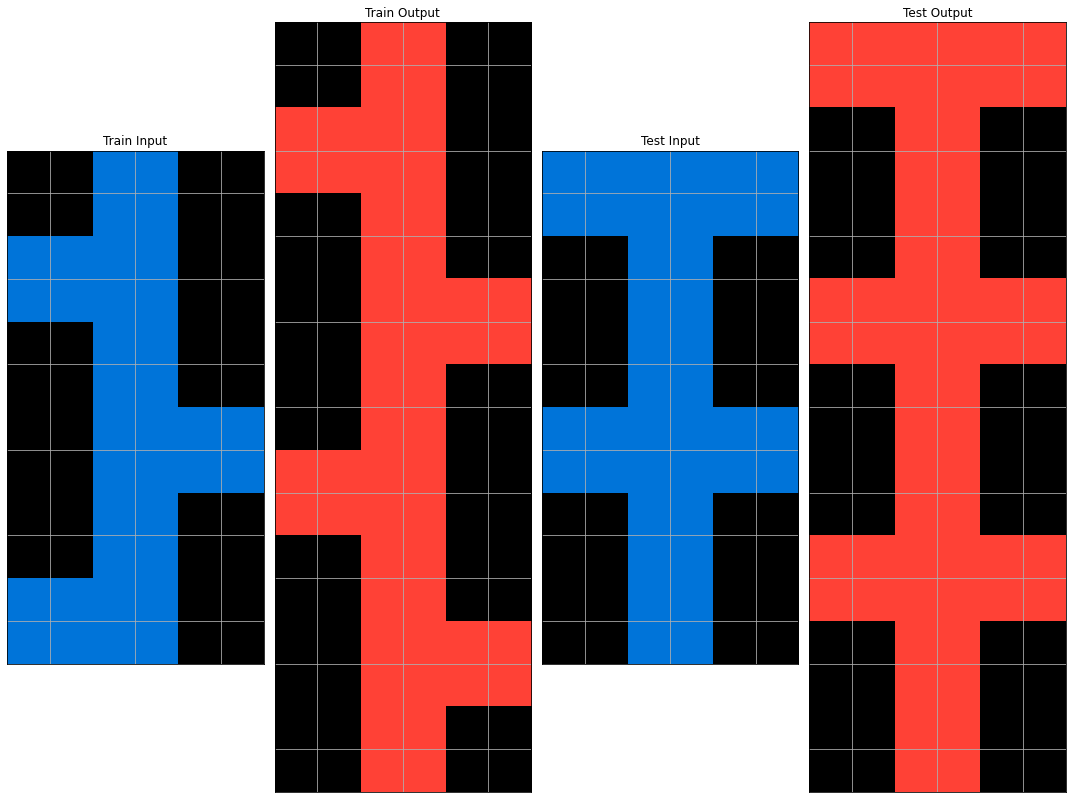

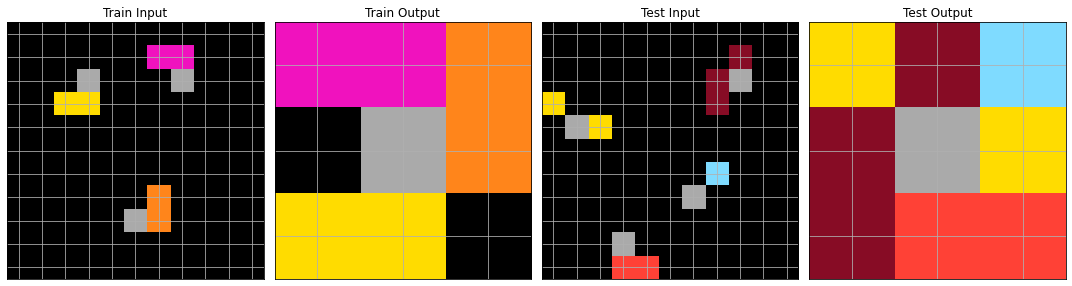

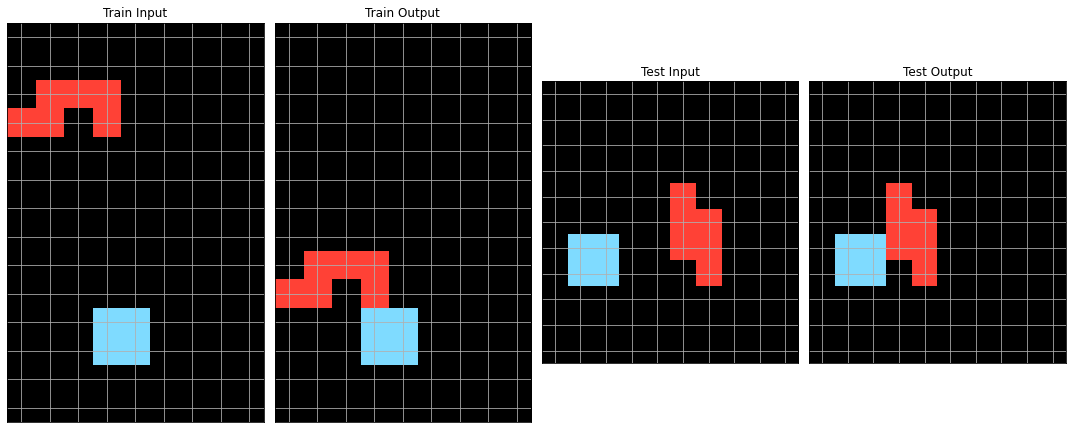

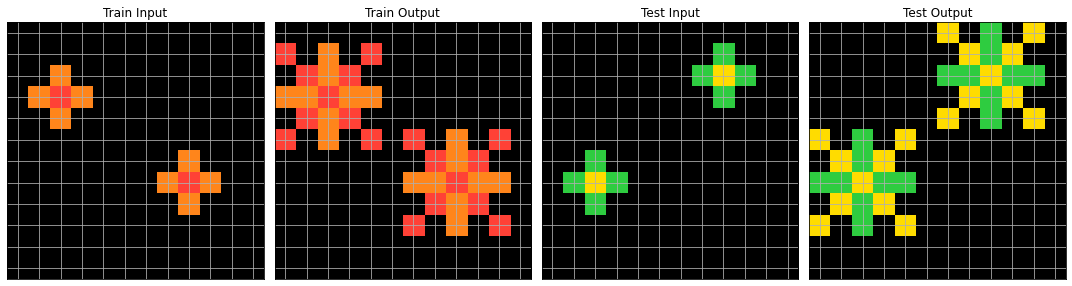

In [0]:
for i in [2, 21, 7, 11, 6]:

    task_file = str(training_path / training_tasks[i])

    with open(task_file, 'r') as f:
        task = json.load(f)

    def plot_task(task):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """
        cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        norm = colors.Normalize(vmin=0, vmax=9)
        fig, ax = plt.subplots(1, 4, figsize=(15,15))
        ax[0].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
        width = np.shape(task['train'][0]['input'])[1]
        height = np.shape(task['train'][0]['input'])[0]
        ax[0].set_xticks(np.arange(0,width))
        ax[0].set_yticks(np.arange(0,height))
        ax[0].set_xticklabels([])
        ax[0].set_yticklabels([])
        ax[0].tick_params(length=0)
        ax[0].grid(True)
        ax[0].set_title('Train Input')
        ax[1].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
        width = np.shape(task['train'][0]['output'])[1]
        height = np.shape(task['train'][0]['output'])[0]
        ax[1].set_xticks(np.arange(0,width))
        ax[1].set_yticks(np.arange(0,height))
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].tick_params(length=0)
        ax[1].grid(True)
        ax[1].set_title('Train Output')
        ax[2].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
        width = np.shape(task['test'][0]['input'])[1]
        height = np.shape(task['test'][0]['input'])[0]
        ax[2].set_xticks(np.arange(0,width))
        ax[2].set_yticks(np.arange(0,height))
        ax[2].set_xticklabels([])
        ax[2].set_yticklabels([])
        ax[2].tick_params(length=0)
        ax[2].grid(True)
        ax[2].set_title('Test Input')
        ax[3].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
        width = np.shape(task['test'][0]['output'])[1]
        height = np.shape(task['test'][0]['output'])[0]
        ax[3].set_xticks(np.arange(0,width))
        ax[3].set_yticks(np.arange(0,height))
        ax[3].set_xticklabels([])
        ax[3].set_yticklabels([])
        ax[3].tick_params(length=0)
        ax[3].grid(True)
        ax[3].set_title('Test Output')
        plt.tight_layout()
        plt.show()

    plot_task(task)

In [0]:
px.histogram(df, x="values", title="Numbers present in matrices")

In [0]:
means = [np.mean(X) for X in matrices]
fig = ff.create_distplot([means], group_labels=["Means"], colors=["green"])
fig.update_layout(title_text="Distribution of matrix mean values")

In [4]:
heights = [np.shape(matrix)[0] for matrix in matrices]
widths = [np.shape(matrix)[1] for matrix in matrices]
fig = ff.create_distplot([heights], group_labels=["Height"], colors=["magenta"])
fig.update_layout(title_text="Distribution of matrix heights")

In [5]:
fig = ff.create_distplot([widths], group_labels=["Width"], colors=["red"])
fig.update_layout(title_text="Distribution of matrix widths")

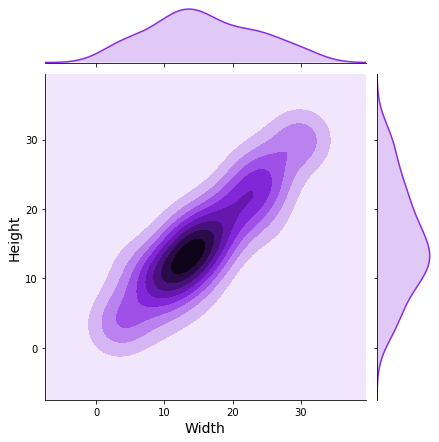

In [0]:
plot = sns.jointplot(widths, heights, kind="kde", color="blueviolet")
plot.set_axis_labels("Width", "Height", fontsize=14)
plt.show(plot)

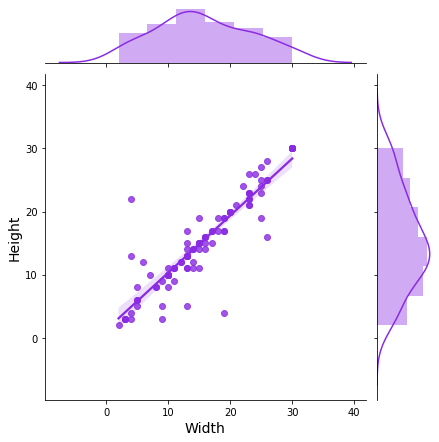

In [0]:
plot = sns.jointplot(widths, heights, kind="reg", color="blueviolet")
plot.set_axis_labels("Width", "Height", fontsize=14)
plt.show(plot)

In [0]:
def replace_values(a, d):
    return np.array([d.get(i, -1) for i in range(a.min(), a.max() + 1)])[a - a.min()]

def repeat_matrix(a):
    return np.concatenate([a]*((SIZE // len(a)) + 1))[:SIZE]

def get_new_matrix(X):
    if len(set([np.array(x).shape for x in X])) > 1:
        X = np.array([X[0]])
    return X

def get_outp(outp, dictionary=None, replace=True):
    if replace:
        outp = replace_values(outp, dictionary)

    outp_matrix_dims = outp.shape
    outp_probs_len = outp.shape[0]*outp.shape[1]*10
    outp = to_categorical(outp.flatten(),
                          num_classes=10).flatten()

    return outp, outp_probs_len, outp_matrix_dims

In [0]:
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train"):
        self.X = get_new_matrix(X)
        self.X = repeat_matrix(self.X)
        
        self.stage = stage
        if self.stage == "train":
            self.y = get_new_matrix(y)
            self.y = repeat_matrix(self.y)
        
    def __len__(self):
        return SIZE
    
    def __getitem__(self, idx):
        inp = self.X[idx]
        if self.stage == "train":
            outp = self.y[idx]

        if idx != 0:
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dictionary = dict(zip(orig, rep))
            inp = replace_values(inp, dictionary)
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, dictionary)
                
        if idx == 0:
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, None, False)
        
        return inp, outp, outp_probs_len, outp_matrix_dims, self.y

In [0]:
class BasicCNNModel(nn.Module):
    def __init__(self, inp_dim=(10, 10), outp_dim=(10, 10)):
        super(BasicCNNModel, self).__init__()
        
        CONV_IN = 3
        KERNEL_SIZE = 3
        DENSE_IN = CONV_OUT_2
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(DENSE_IN, outp_dim[0]*outp_dim[1]*10)
        
        if inp_dim[0] < 5 or inp_dim[1] < 5:
            KERNEL_SIZE = 1

        self.conv2d_1 = nn.Conv2d(CONV_IN, CONV_OUT_1, kernel_size=KERNEL_SIZE)
        self.conv2d_2 = nn.Conv2d(CONV_OUT_1, CONV_OUT_2, kernel_size=KERNEL_SIZE)

    def forward(self, x, outp_dim):
        x = torch.cat([x.unsqueeze(0)]*3)
        x = x.permute((1, 0, 2, 3)).float()
        self.conv2d_1.in_features = x.shape[1]
        conv_1_out = self.relu(self.conv2d_1(x))
        self.conv2d_2.in_features = conv_1_out.shape[1]
        conv_2_out = self.relu(self.conv2d_2(conv_1_out))
        
        self.dense_1.out_features = outp_dim
        feature_vector, _ = torch.max(conv_2_out, 2)
        feature_vector, _ = torch.max(feature_vector, 2)
        logit_outputs = self.dense_1(feature_vector)
        
        out = []
        for idx in range(logit_outputs.shape[1]//10):
            out.append(self.softmax(logit_outputs[:, idx*10: (idx+1)*10]))
        return torch.cat(out, axis=1)

In [0]:
def transform_dim(inp_dim, outp_dim, test_dim):
    return (test_dim[0]*outp_dim[0]/inp_dim[0],
            test_dim[1]*outp_dim[1]/inp_dim[1])

def resize(x, test_dim, inp_dim):
    if inp_dim == test_dim:
        return x
    else:
        return cv2.resize(flt(x), inp_dim,
                          interpolation=cv2.INTER_AREA)

def flt(x): return np.float32(x)
def npy(x): return x.cpu().detach().numpy()
def itg(x): return np.int32(np.round(x))

In [8]:
idx = 0
start = time.time()
test_predictions = []

for X_train, y_train in zip(Xs_train, ys_train):
    print("TASK " + str(idx + 1))

    train_set = ARCDataset(X_train, y_train, stage="train")
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    inp_dim = np.array(X_train[0]).shape
    outp_dim = np.array(y_train[0]).shape
    network = BasicCNNModel(inp_dim, outp_dim).cuda()
    optimizer = Adam(network.parameters(), lr=0.01)
    
    for epoch in range(EPOCHS):
        for train_batch in train_loader:
            train_X, train_y, out_d, d, out = train_batch
            train_preds = network.forward(train_X.cuda(), out_d.cuda())
            train_loss = nn.MSELoss()(train_preds, train_y.cuda())
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

    end = time.time()        
    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " +\
          "Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    X_test = np.array([resize(flt(X), np.shape(X), inp_dim) for X in Xs_test[idx-1]])
    for X in X_test:
        test_dim = np.array(T(X)).shape
        test_preds = npy(network.forward(T(X).unsqueeze(0).cuda(), out_d.cuda()))
        test_preds = np.argmax(test_preds.reshape((10, *outp_dim)), axis=0)
        test_predictions.append(itg(resize(test_preds, np.shape(test_preds),
                                           tuple(itg(transform_dim(inp_dim,
                                                                   outp_dim,
                                                                   test_dim))))))
    idx += 1

TASK 1
Train loss: 0.086   Total time: 19.5 s

TASK 2
Train loss: 0.048   Total time: 54.4 s

TASK 3
Train loss: 0.031   Total time: 66.4 s

TASK 4
Train loss: 0.041   Total time: 86.5 s

TASK 5
Train loss: 0.067   Total time: 227.7 s

TASK 6
Train loss: 0.071   Total time: 310.3 s

TASK 7
Train loss: 0.073   Total time: 328.1 s

TASK 8
Train loss: 0.038   Total time: 423.7 s

TASK 9
Train loss: 0.046   Total time: 447.9 s

TASK 10
Train loss: 0.087   Total time: 456.1 s

TASK 11
Train loss: 0.04   Total time: 597.8 s

TASK 12
Train loss: 0.088   Total time: 604.9 s

TASK 13
Train loss: 0.044   Total time: 626.0 s

TASK 14
Train loss: 0.036   Total time: 666.5 s

TASK 15
Train loss: 0.071   Total time: 677.6 s

TASK 16
Train loss: 0.046   Total time: 698.9 s

TASK 17
Train loss: 0.078   Total time: 711.8 s

TASK 18
Train loss: 0.09   Total time: 721.2 s

TASK 19
Train loss: 0.038   Total time: 787.6 s

TASK 20
Train loss: 0.049   Total time: 819.5 s

TASK 21
Train loss: 0.063   Total t

In [0]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [0]:
test_predictions = [[list(pred) for pred in test_pred] for test_pred in test_predictions]

for idx, pred in enumerate(test_predictions):
    test_predictions[idx] = flattener(pred)
    
submission = pd.read_csv(SUBMISSION_PATH)
submission["output"] = test_predictions

In [0]:
submission.head()

output_id                                             output
0  00576224_0        |150826|593265|989609|373508|315982|759896|
1  009d5c81_0  |74508616947403|81619423038361|94705031619472|...
2  00dbd492_0  |9013545|6789012|3456789|0124564|7890323|55678...
3  03560426_0  |0410010000|3810010000|2830331433|5133464344|4...
4  05a7bcf2_0  |187334333386733273331773307744|17592044470382...

In [0]:
submission.to_csv("submission.csv", index=False)

In [0]:
from google.colab import files
files.download('submission.csv') 